In [1]:
import numpy as np
import stochoptim.stochprob.network_design.network_design_problem as ndp
import stochoptim.stochprob.network_design.network_design_solution as nds
import stochoptim.stochprob.network_design.network_design_uncertainty as ndu
from stochoptim.scenclust.cost_space_partition import CostSpaceScenarioPartitioning
import stochoptim.scengen.scenario_tree as st
np.set_printoptions(linewidth=120)

### Generate Problem Parameters

In [2]:
n_origins = 2
n_destinations = 2
n_intermediates = 2
#------------
param = ndp.generate_random_parameters(n_origins, n_destinations, n_intermediates)
param

{'n_origins': 2,
 'n_destinations': 2,
 'n_intermediates': 2,
 'opening_cost': array([[ 9,  6,  4,  7,  4,  5],
        [ 4,  4, 10,  7,  3, 10],
        [ 8,  6, 10,  8,  3, 10],
        [ 8,  4, 10,  9,  9,  9],
        [ 7,  9,  6,  8,  5,  5],
        [ 3,  6, 10,  6,  8,  4]]),
 'shipping_cost': array([[   8,    5,    9,    5, 1000, 1000],
        [   6,    7,    8,    8, 1000, 1000],
        [   9,    6,   10,    9,    6,    8],
        [   7,    9,    8,    5,   10,    8],
        [   8,    8,    9,    9,    8,   10],
        [   5,    5,    9,    7,   10,    8]]),
 'capacity': array([[    23,     15,     23,     13, 100000, 100000],
        [    12,     14,     34,     39, 100000, 100000],
        [    32,     27,     25,     28,     32,     38],
        [    11,     20,     13,     32,     34,     17],
        [    24,     29,     24,     15,     31,     36],
        [    16,     18,     37,     27,     17,     34]])}

### Instantiate Problem

In [3]:
network_problem = ndp.NetworkDesign(param)
network_problem

Network Design Problem: (2 stages)
  - decision variables: [26, 120]
    - stage 0: 
      - y: 26 (b)
    - stage 1: 
      - z: 120 (c)
  - random variables: [0, 4]
    - stage 1: 
      - d: 4

Network: 
  6 nodes
  26 transportation arcs
  4 commodities

### Instantiate Uncertainty

#### Lognormal Demand

In [20]:
n_scenarios = 10
distribution = 'lognormal'
mean = 1
std = 1
#------------------
network_uncertainty = ndu.Demands(n_scenarios=n_scenarios, 
                                  n_commodities=n_destinations*n_origins, 
                                  distribution=distribution,
                                  mean=mean, 
                                  std=std)
network_uncertainty

Commodity demand uncertainty: logN(1,1)-corr0 
  - scenarios: 10 
  - features: 4 
    - d: 4 

### Build Original Scenario Tree (with all scenarios)

In [21]:
scenario_tree = network_uncertainty.get_scenario_tree()
scenario_tree.to_numpy()

array([[18,  9,  0,  4],
       [ 2,  2, 16,  7],
       [ 0,  6,  3,  7],
       [ 1,  0,  1, 19],
       [ 5,  0,  2,  1],
       [ 1,  1,  1,  3],
       [ 2,  2,  1,  4],
       [ 3,  3,  1,  4],
       [ 6,  2,  1,  5],
       [ 5,  6,  4,  1]], dtype=int64)

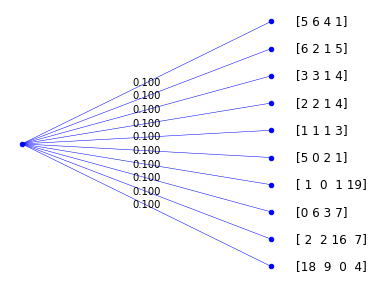

In [22]:
scenario_tree.plot('d')

### Compute opportunity cost matrix

In [23]:
opportunity_cost_matrix = network_problem.compute_opportunity_cost(scenario_tree, return_matrix=True, 
                                                                   relaxation_step1=True, relaxation_step2=True,
                                                                   verbose=0, logfile=None, decomposition=False)

Solve Wait-and-See Problems... Finished 0.198 sec
Evaluate Wait-and-See Solution #0... Finished 0.084 sec
Evaluate Wait-and-See Solution #1... Finished 0.082 sec
Evaluate Wait-and-See Solution #2... Finished 0.082 sec
Evaluate Wait-and-See Solution #3... Finished 0.084 sec
Evaluate Wait-and-See Solution #4... Finished 0.079 sec
Evaluate Wait-and-See Solution #5... Finished 0.090 sec
Evaluate Wait-and-See Solution #6... Finished 0.083 sec
Evaluate Wait-and-See Solution #7... Finished 0.084 sec
Evaluate Wait-and-See Solution #8... Finished 0.078 sec
Evaluate Wait-and-See Solution #9... Finished 0.150 sec


In [24]:
np.round(opportunity_cost_matrix)

array([[  468., 19129.,  6153., 16094.,   136.,   107.,  1135.,  1163.,  2195.,  1226.],
       [23133.,   405.,  4193., 12154.,  3087.,   103.,   147.,  2147.,  4163.,  7141.],
       [21153., 15191.,   243., 13137.,  5055.,  1086.,  2115.,  3128.,  6131.,  6147.],
       [26090., 17168.,  6168.,   344.,  5055.,  1088.,  3104.,  5104.,  7120., 12072.],
       [25094., 21092., 12062., 18048.,   122.,  3048.,  5063.,  6078.,  7108.,  8122.],
       [26079., 21093., 10093., 16080.,  5047.,    93.,  3093.,  5093.,  8093., 11077.],
       [23125., 18139.,  7139., 15098.,  4064.,    95.,   139.,  2139.,  5139.,  8123.],
       [21155., 18139.,  6154., 15100.,  3081.,    97.,   141.,   169.,  4156.,  5169.],
       [19187., 17149.,  6157., 14116.,   126.,    97.,   141.,   173.,   217.,  3201.],
       [19179., 18136.,  6146., 18055.,   129.,  2068.,  3096.,  3124.,  5141.,   235.]])

### Run Cost-Space-Scenario-Clustering (CSSC) Algorithm

In [25]:
cssc = CostSpaceScenarioPartitioning(opportunity_cost_matrix)

In [26]:
cssc.solve_mip(cardinality=2)

In [27]:
cssc.solution_mip

{'partition': ((0, 4, 5, 7, 8, 9), (1, 2, 3, 6)),
 'representatives': (0, 1),
 'weights': array([0.6, 0.4]),
 'score': 1776.6000000000001,
 'time': 0.030999999959021807,
 'bound': 1776.6000000000001,
 'status': 101}

### Build Approximate Scenario Tree (with the clustered scenarios)

In [28]:
clustered_scenarios = scenario_tree.to_numpy()[cssc.solution_mip['representatives'], :]
clustered_scenarios

array([[18,  9,  0,  4],
       [ 2,  2, 16,  7]], dtype=int64)

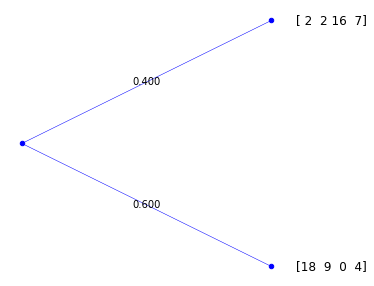

In [29]:
clustered_scenario_tree = st.twostage_from_scenarios(scenarios=clustered_scenarios, 
                                                     n_rvar={'d': 4},
                                                     weights=cssc.solution_mip['weights'])
clustered_scenario_tree.plot('d')

### Solve the problem on the clustered scenario tree

In [30]:
network_solution_clustering = network_problem.solve(clustered_scenario_tree)
network_solution_clustering

Number of scenario trees: 1 (bushiness: [2.0]) 

Initialize model... Finished. (0.015 sec).
Initialize variables... Finished. (0.003 sec).
Add deterministic constraints at subroot #1... Finished. (0.005 sec).
Define objective function at subtree #1... Finished. (0.006 sec).

Solve scenario tree #1... 
  Precompute variables and parameters... Finished. (0.000 sec).
  Check parameters validity... Finished. (0.000 sec).
  Add random constraints at subtree #1... Finished. (0.009 sec).
  Solve problem at subtree #1... Finished. (0.073 sec).
  Fill scenario tree... Finished. (0.001 sec).
Finished. (0.085 sec).


obj=467.400, gap=0.000%, time=0.1 sec

### Evaluate the stage-0 decisions using the original scenario tree 

In [31]:
# This is a decision process, i.e., an object that freezes some decisions in the problem before solving it.
# Here we freeze the stage-0 decisions and we will optimize only over the stage-1 decisions.
stage_0_decisions = network_solution_clustering.decision_process_fixed({0: ['y']})
stage_0_decisions

Decision process: (2 stages)
  - decision variables: [26, 120]
    - stage 0: 
      - y: 26 (fixed: 26, callable: 0)
    - stage 1: 
      - z: 120

In [32]:
network_solution = network_problem.solve(scenario_tree, 
                                         decision_process=stage_0_decisions)
network_solution

Number of scenario trees: 1 (bushiness: [10.0]) 

Problem is decomposed at stage 1 (10 subtrees).
Initialize model... Finished. (0.077 sec).
Initialize variables... Finished. (0.005 sec).
Add deterministic constraints at subroot #10... Finished. (0.017 sec).
Define objective function at subtree #10... Finished. (0.009 sec).

Solve scenario tree #1... 
  Precompute variables and parameters... Finished. (0.000 sec).
  Check parameters validity... Finished. (0.000 sec).
  Add random constraints at subtree #10... Finished. (0.024 sec).
  Solve problem at subtree #10... Finished. (0.216 sec).
  Fill scenario tree... Finished. (0.003 sec).
Finished. (0.246 sec).


obj=471.600, gap=nan%, time=0.0 sec

### Plot solution

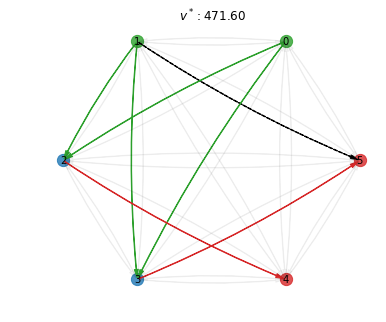

In [33]:
network_solution.plot_network()

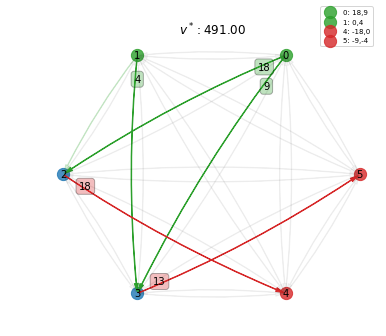

In [34]:
network_solution.plot_network(scen_index=0)